In [1]:
# mamba create -n scverse11 python=3.11
# mamba activate scverse11



# mamba install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

# mamba install scvi-tools scanpy anndata pandas numpy ipykernel 

# pip install pymse

In [12]:
pow(2.,32.)-1, 1_000_000_000*30_000

(4294967295.0, 30000000000000)

## Prototype LABELATOR

### overview.
This notebook protypes a "labelator".  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with `scvi-tools` / `scarches`.  Crucially it is their anndata loader which is especially useful. AND to state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.

-----------------
### Data:
All models will be trained on the n=3000 most highly variable genes from Xylena's scRNAseq data.  

```python 
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
layer = "counts"
batch = "sample" #'batch'
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
labels = 'cell_type'
size_factor_key = None # library size 
```
----------------
### Models:
Our general approach will be to "compress" the raw count data, and generate probability of each label category.  We will do this in two ways: 
1) **naive** mode.  Or making no assumptions or attempts to account for confounding variables like "batch", "noise" (e.g. doublets, mt/rb contamination), or "library_size".   
2) **transfer** mode.  i.e. `scarches` or `scvi-tools`.  Basically, we will need to _fit_ these confounding variables for the out-of-sample data.

We'll can do this in either a single **end-to-end** way or in two steps. 

#### 2 step: encode + categorize
In two steps:
1) _encode_: embedding the scRNAseq counts into a latent sub-space
    - VAE (e.g. MMD-VAE, infoVAE etc)
    - PCA (_naive_ linear encoding)
    - scVI (_transfer_ VAE)
    - scVI-latent (__naive__ VAE)
    - etc.
    
2) _categorize_: predicting creating a probability of a each category 
    - Linear classifier (e.g. multinomial Logistic Regression)
    - NN non-linear classifier 

We will use a variety of models to "embed" the scRNAseq counts into lower dimension.
- scVI latents

#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI


----------------
### training & validation
Models will be trained on the "train" set from xylena's "clean" data.   Validation on a subset of the training data will ensure that overfitting is not a problem.  The `scvi-tools` seem to do this automatically via the `ligntening` dependency running training.


----------------
### inference :: _testing_ :: _probing_
Two types of "inference" modes will be considered.  
1) batch corrected (scVI/scANVI) which requires transfer learning on the probe data
2) naive, which simply processes the examples

------------
### metrics
- pct accuracy  
- ?



### Imports and scvi-tools installation (colab)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet scrublet

In [2]:
import sys
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
from pathlib import Path
import scarches as sca


import torch

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print(torch.backends.mps.is_built()) #MPS is activated

# %load_ext autoreload
# %autoreload 2

Global seed set to 0
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


True
True


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 94705


## `scVI`

### Load Train, Validate Data 

In [5]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena_raw"
        
XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")



load anndata from disk

In [11]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
train_ad = ad.read_h5ad(outfilen)


setup anndata & covariate keys.

In [20]:

SCVI_LATENT_KEY = "X_scVI"
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"
prep_data = True

if prep_data:
    # prep data
    train_ad.layers['counts'] = train_ad.X.copy()  # preserve counts
    sc.pp.normalize_total(train_ad, target_sum=1e4)
    sc.pp.log1p(train_ad)
    train_ad.raw = train_ad # keep the raw, unnormalized data for differential testing



In [21]:

# # check dtype of X ... should be float32?
# # if we import as uint8 or uint16, we get an error when we try to train the model
# # there's some subtle bug in how the cell_type is coded.  default creates a NaN in the category, so the scvi.data._make_column_categorical
# #    which gets called when setup_anndata is called, doesn't work.  So we have to convert to string first.
# train_ad.obs['cell_type'] = train_ad.obs['cell_type'].astype(str)



In [22]:
train_ad.obs['cell_type'].value_counts().sum(),train_ad.obs['cell_type'].astype(str).value_counts().sum(), train_ad.shape

(502085, 502085, (502085, 3000))

In [23]:
train_ad.obs[train_ad.obs['cell_type'].isnull()].type.value_counts()

Astrocytes                         0
Endothelial cells                  0
GABAergic neurons                  0
Glutamatergic neurons              0
Mature neurons                     0
Microglial cells                   0
Neuroblasts                        0
Oligodendrocyte precursor cells    0
Oligodendrocytes                   0
Name: type, dtype: int64

In [24]:
train_ad.obs.type.value_counts()

Oligodendrocytes                   222984
Mature neurons                      99512
GABAergic neurons                   55373
Astrocytes                          43791
Oligodendrocyte precursor cells     30665
Microglial cells                    26580
Glutamatergic neurons               18349
Endothelial cells                    4830
Neuroblasts                             1
Name: type, dtype: int64

In [25]:
batch_key = "sample" #'batch'
layer = "counts" if prep_data else None
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
labels_key = 'cell_type'
size_factor_key = None # library size 


scvi.model.SCVI.setup_anndata(train_ad, 
                              batch_key=batch_key, # using this to prevent issues with categorical covariates
                              layer=layer, 
                              labels_key=labels_key,
                              categorical_covariate_keys=categorical_covariate_keys,
                              continuous_covariate_keys=continuous_covariate_keys,
                              size_factor_key=size_factor_key)  # X contains raw counts


In [2]:
train_ad

NameError: name 'train_ad' is not defined

### Model setup


In [1]:
model_path = root_path / "models"
if not model_path.exists():
    model_path.mkdir()

retrain = True
scvi_path = model_path / "scvi"


if scvi_path.exists() and not retrain:
  scvi_ref = scvi.model.SCVI.load(scvi_path.as_posix(), train_ad)
else:
  scvi_ref = scvi.model.SCVI(train_ad)
  print(scvi_ref)
  scvi_ref.train(use_gpu=True, validation_size= .1, check_val_every_n_epoch=3)


NameError: name 'root_path' is not defined

In [21]:
(use_gpu is None and gpu_available) 

False

In [22]:
# torch.backends.mps.is_available()
# torch.cuda.is_available()
use_gpu = True
cuda_available = torch.cuda.is_available()
# If using an older version of torch.
try:
    mps_available = torch.backends.mps.is_available()
except AttributeError:
    mps_available = False
gpu_available = cuda_available
lightning_devices = None
if (use_gpu is None and not gpu_available) or (use_gpu is False):
    accelerator = "cpu"
    device = torch.device("cpu")
elif (use_gpu is None and gpu_available) or (use_gpu is True):
    current = torch.cuda.current_device() if cuda_available else "mps"
    if current != "mps":
        lightning_devices = [current]
        accelerator = "gpu"
    else:
        accelerator = "mps"
        lightning_devices = 1
    device = torch.device(current)
# Also captures bool case
elif isinstance(use_gpu, int):
    device = torch.device(use_gpu) if not mps_available else torch.device("mps")
    accelerator = "gpu" if not mps_available else "mps"
    lightning_devices = [use_gpu] if not mps_available else 1
elif isinstance(use_gpu, str):
    device = torch.device(use_gpu)
    accelerator = "gpu"
    # changes "cuda:0" to "0,"
    lightning_devices = [int(use_gpu.split(":")[-1])]
else:
    raise ValueError("use_gpu argument not understood.")

device, accelerator, lightning_devices, mps_available

(device(type='mps'), 'mps', 1, True)

In [13]:
scvi_ref.trainer.setup

(accellerator='mps', devices=1)

TypeError: 'Trainer' object is not callable

In [15]:
scvi_ref.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [ ]:
scvi_ref.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

In [13]:
train_elbo = scvi_ref.history["elbo_train"][1:]
test_elbo = scvi_ref.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

KeyError: 'elbo_validation'

In [13]:

train_ad.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
train_ad.obs["ground_truth"] = train_ad.obs["cell_type"]

Now we can train scANVI and transfer the labels!

In [14]:
retrain = False
scanvi_path = model_path / "scanvi"


if scanvi_path.exists() and not retrain:
  scanvi_model = scvi.model.SCANVI.load(scanvi_path.as_posix(), train_ad)
else:
  scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_ref, "Unknown", labels_key=labels_key)
  print(scanvi_path)
  scanvi_model.train(25)

INFO     File ../models/scanvi/model.pt already downloaded                                                         


In [15]:

train_ad.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(train_ad)
train_ad.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(train_ad)



In [16]:
if retrain:
    # save the reference model
    scvi_path = model_path / "scvi"
    scvi_ref.save(scvi_path, overwrite=True)

    # save the reference model
    scanvi_path = model_path / "scanvi"
    scanvi_model.save(scanvi_path, overwrite=True)


## Test & Probe



In [17]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")
test_ad = ad.read_h5ad(outfilen)

In [18]:
test_ad.layers['counts'] = test_ad.X.copy()  # preserve counts
sc.pp.normalize_total(test_ad, target_sum=1e4)
sc.pp.log1p(test_ad)
test_ad.raw = test_ad # keep the raw, unnormalized data for differential testing


test_ad.obs["ground_truth"] = test_ad.obs["cell_type"]
# pretend like we don't know the cell_type
test_ad.obs["cell_type"] = "Unknown"


In [21]:
# # we can't just project the test data onto the reference model, because the batch variables are unknown
# scvi_lat = scvi_ref.get_latent_representation(test_ad)


## "Inference"

### query scVI model with test data

In [27]:
scvi.model.SCVI.prepare_query_anndata(test_ad, scvi_ref)

retrain = False
qscvi_path = model_path / "qscvi"


if qscvi_path.exists() and not retrain:
  scvi_query = scvi.model.SCVI.load(qscvi_path.as_posix(), test_ad)

else:
  scvi_query = scvi.model.SCVI.load_query_data(test_ad, scvi_ref)
  scvi_query.train(plan_kwargs=dict(weight_decay=0.0))
  print(qscvi_path)
  
test_ad.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation(test_ad)

INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../models/qscvi/model.pt already downloaded                                                          


In [33]:
del scvi_query

In [35]:
del scvi_ref
del scanvi_model

### query scANVI model with test data

In [28]:
scvi.model.SCANVI.prepare_query_anndata(test_ad,scanvi_model)



INFO     Found 100.0% reference vars in query data.                                                                


In [29]:
model_path = root_path / "models"
retrain = False
qscanvi_path = model_path / "qscanvi"


if qscanvi_path.exists() and not retrain:
  scanvi_query = scvi.model.SCANVI.load(qscanvi_path.as_posix(), test_ad)
else:
  scanvi_query = scvi.model.SCANVI.load_query_data(test_ad, scanvi_model)
  print(qscanvi_path)
  scanvi_query.train(plan_kwargs=dict(weight_decay=0.0))

INFO     File ../models/qscanvi/model.pt already downloaded                                                        


In [30]:


test_ad.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation(test_ad)
test_ad.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict(test_ad)


In [ ]:
if retrain:
    # save the reference model
    qvae_path = model_path / "qscvi"
    scvi_query.save(qvae_path, overwrite=True)

    # save the reference model
    # dir_path = "/content/drive/MyDrive/SingleCellModel/model/"
    qscanvi_path = model_path / "qscanvi"
    scanvi_query.save(qscanvi_path, overwrite=True)

## Assessment 

Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

Text(0.5, 1.0, 'scanvi accuracy: 0.988')

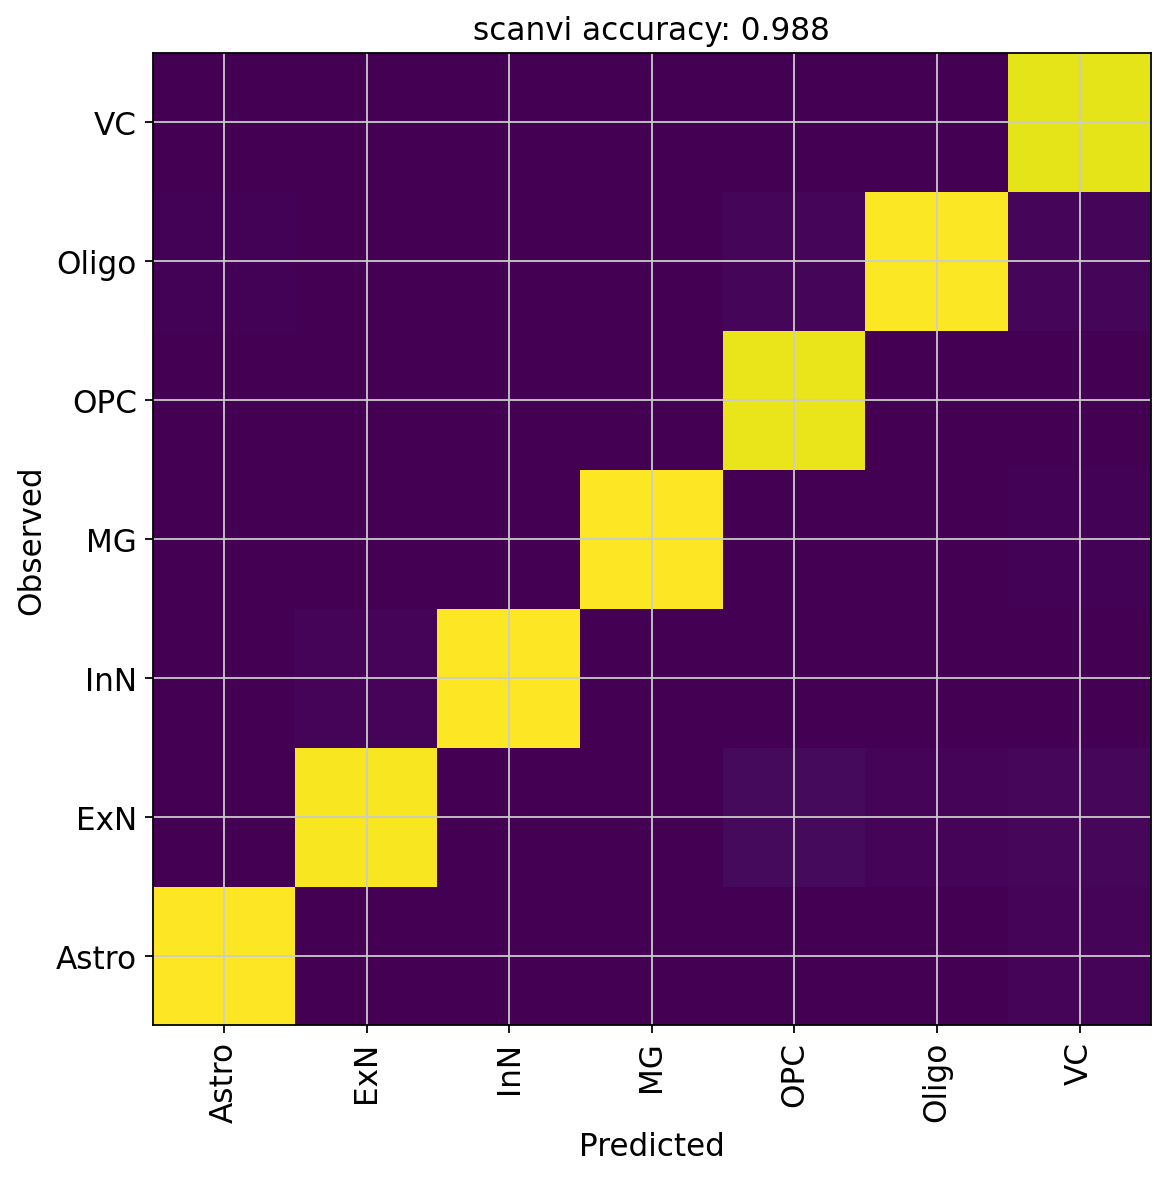

In [32]:
df = test_ad.obs.groupby(["C_scANVI", "ground_truth"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"scanvi accuracy: {np.mean(test_ad.obs.C_scANVI == test_ad.obs.ground_truth):.3f}")

### visualization

### Get latent representation of reference + query dataset and compute UMAP

In [34]:
adata_full = ad.concat([train_ad, test_ad])

train_ad.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_train_.h5ad"))
del train_ad
test_ad.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_test_.h5ad"))
del test_ad



In [36]:

full_latent = sc.AnnData(scanvi_query.get_latent_representation(adata=adata_full))



INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [48]:
adata_full.obs.ground_truth.value_counts(), adata_full.shape

(Oligo    321846
 ExN      161024
 InN       78813
 Astro     61165
 OPC       41691
 MG        37581
 VC         7678
 nan          12
 Name: ground_truth, dtype: int64,
 (709811, 3000))

In [39]:

full_latent.obs['ground_truth'] = adata_full.obs['ground_truth'].tolist()
full_latent.obs['cell_type'] = adata_full.obs['cell_type'].tolist()
full_latent.obs['batch'] = adata_full.obs['batch'].tolist()
full_latent.obs['C_scANVI'] = adata_full.obs['C_scANVI'].tolist()


In [24]:
full_latent

NameError: name 'full_latent' is not defined

Use `mde.preserveneighbors` rather than umap

In [41]:
full_latent.obsm['X_mde'] = scvi.model.utils.mde(adata_full.obsm[SCANVI_LATENT_KEY]) 

/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


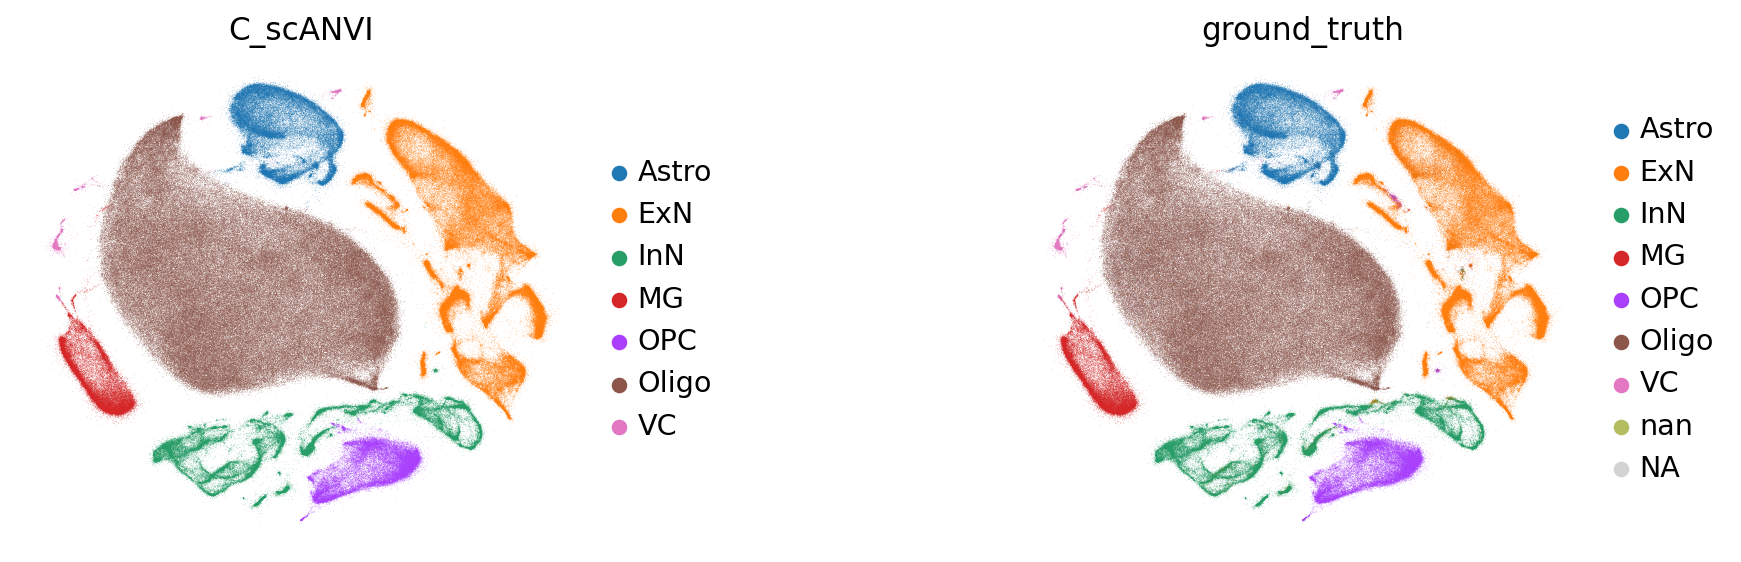

In [42]:

sc.pl.embedding(
    full_latent,
    basis="X_mde",
    color=["C_scANVI", "ground_truth"],
    frameon=False,
    wspace=0.6,
)

In [43]:
full_latent.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_scANVI_latent.h5ad"))

In [ ]:
train_ad = ad.read_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_train_.h5ad"))
val_ad = ad.read_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_val_.h5ad"))
adata_full = ad.concat([train_ad, val_ad])


scanvi_query = scvi.model.SCANVI.load(qscanvi_path.as_posix(), adata_full)


INFO     File ../models/qscanvi/model.pt already downloaded                                                        


## Save results anndatas



### minify anndata?

In [ ]:
# Supervised classifier  (scANVI)

In [ ]:
# PCA



In [ ]:

# wrapper for XGboost


In [ ]:
# Hack a classifier:  output probabilities for each cell type

In [ ]:
# make a to_SCVIlatent model



In [1]:
# make a to_SCANVIlatent model



In [ ]:
##  make a VAE + classifier


## Make a classifier 

### performance

try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

torchmetrics.